# Singapore Condo Rental Data Analysis & Prediction

## Introduction

Pupose of the project is to make a model to predict the rental price of condos based on other factors that decides the rent.

Multi Linear Regression algorithm is used to predict the model

## Implementation Steps

### Dataset

The dataset for the analysis is taken from Rental contracts of private residential properties from URA [ https://www.ura.gov.sg/realEstateIIWeb/resiRental/submitSort.action ]

The dataset includes the details such as Building/Project Name, Street Name, Postal District, No. of Bedroom(for Non-Landed Only), Floor Area (sq ft), Lease Commencement Date and the rental price

### Initialisation

Import all the libraries needed for this data analysis

In [2]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as pyplot
# seaborn for making statistical graphics in Python
import seaborn as sns 
import pickle

from collections import Counter

#StandardScalre - Standardize features by removing the mean and scaling to unit variance
# LabelEncoder - converts each string value into a number
from sklearn.preprocessing import StandardScaler, LabelEncoder
# metrics implements functions assessing prediction error for specific purposes.
# includes score functions, performance metrics and pairwise metrics and distance computations.
from sklearn import metrics
from sklearn import svm

from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# for computing
from scipy.stats import uniform, randint
from sklearn.utils.fixes import loguniform
import qgrid


IPython core display supports the display

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(16, 12)})

### Data pre-processing

Define the variables in the input dataset

In [4]:
# Names of the columns in the input dataset
col_building = 'Building/Project Name'
col_street_name = 'Street Name'
col_postal_district = 'Postal District'
col_num_bedroom = 'No. of Bedroom(for Non-Landed Only)'
col_monthly_rent = 'Monthly Gross Rent($)'
col_floor_area = 'Floor Area (sq ft)'
col_lease_date = 'Lease Commencement Date'
# Names of the columns after regression and prediction.
# Used mainly for visualization purpose
col_actual_price = 'Actual Price'
col_predicted_price = 'Predicted Price'
col_floor_area_nosqft = 'Floor Area'
col_building_name = 'Building Name'

#### Data Loading

Import the dataset and read it using "pandas" and store as the dataframe


In [5]:
# import the dataset
complete_condo_data = pd.read_csv('Rental-Contracts-Non-Landed-Housing-Dev - removedNA.csv')
complete_condo_data.columns

Index(['S/N', 'Building/Project Name', 'Street Name', 'Postal District',
       'Type', 'No. of Bedroom(for Non-Landed Only)', 'Monthly Gross Rent($)',
       'Floor Area (sq ft)', 'Lease Commencement Date'],
      dtype='object')

#### Drop unwanted columns from the data

In [6]:
columns_to_drop = ['S/N', 'Type']
valid_condo_data = complete_condo_data.drop(columns = columns_to_drop)
valid_condo_data.head()

,Building/Project Name,Street Name,Postal District,No. of Bedroom(for Non-Landed Only),Monthly Gross Rent($),Floor Area (sq ft),Lease Commencement Date
0,EMERALD PARK,INDUS ROAD,3,2,3200,900 to 1000,Feb-21
1,V ON SHENTON,SHENTON WAY,1,1,3700,700 to 800,Feb-21
2,MARINA BAY RESIDENCES,MARINA BOULEVARD,1,2,5850,1100 to 1200,Feb-21
3,THE TRILINQ,JALAN LEMPENG,5,1,2250,500 to 600,Feb-21
4,PEOPLE'S PARK COMPLEX,PARK ROAD,1,1,1800,400 to 500,Feb-21


#### Data Conversion / Encoding

###### Separate Unique Values

Find out the unique values for each string values present in the input data.
This data is taken as a backup before encoding starts.

Backup data will be used later after prediction, to visualize the data


In [7]:
# Store the string values present in the input dataset separately, for future use
# Future use ==> to convert the data back from numeric to string form
building_names_list = valid_condo_data[col_building].unique()
street_names_list = valid_condo_data[col_street_name].unique()
floor_area_list = valid_condo_data[col_floor_area].unique()
lease_date_list = valid_condo_data[col_lease_date].unique()


###### Encoding

The string values of the independent variables in the dataset are converted into numerical values.
Here, both categorical encoding and one-hot encoding is used.

Categorical encoding is used for the building names, because of the big number of data.

In one-hot encoding, each value will be converted to a separate column and this makes the data huge.

To control the size of the data set while keeping the accuracy of prediction, 2 types of encoding are mixed and used.

All other string variables are in limited numbers and can be handled with one-hot encoding.

In [ ]:
valid_condo_data_dummy = valid_condo_data.copy()

# Categorical Encoding for Building names
# convert unique string values with numerical values using Category
valid_condo_data_dummy[col_building] = pd.factorize(valid_condo_data_dummy[col_building])[0]
valid_condo_data_dummy[col_building] = valid_condo_data_dummy[col_building].astype("category")

# One-hot encoding for all other string variables
# Generate dummy columns (while dropping first dummy col (drop_first = True) to prevent collinearity in MLR)
valid_condo_data_dummy = pd.get_dummies(valid_condo_data_dummy, columns = [col_street_name], drop_first = True)
valid_condo_data_dummy = pd.get_dummies(valid_condo_data_dummy, columns = [col_floor_area], drop_first = True)
valid_condo_data_dummy = pd.get_dummies(valid_condo_data_dummy, columns = [col_lease_date], drop_first = True)

###### Data after encoding

In [8]:
valid_condo_data_dummy.head()

,Building/Project Name,Postal District,No. of Bedroom(for Non-Landed Only),Monthly Gross Rent($),Street Name_ADIS ROAD,Street Name_AH HOOD ROAD,Street Name_AKYAB ROAD,Street Name_ALEXANDRA ROAD,Street Name_ALEXANDRA VIEW,Street Name_ALJUNIED ROAD,Street Name_AMBER GARDENS,Street Name_AMBER ROAD,Street Name_ANDERSON ROAD,Street Name_ANG MO KIO AVENUE 1,Street Name_ANG MO KIO AVENUE 2,Street Name_ANG MO KIO AVENUE 8,Street Name_ANG MO KIO AVENUE 9,Street Name_ANG MO KIO CENTRAL 3,Street Name_ANG MO KIO STREET 66,Street Name_ANGKLONG LANE,Street Name_ANGULLIA PARK,Street Name_ANSON ROAD,Street Name_ANTHONY ROAD,Street Name_ARCADIA ROAD,Street Name_ARDMORE PARK,Street Name_ARNASALAM CHETTY ROAD,Street Name_ARTHUR ROAD,Street Name_AVA ROAD,Street Name_BALESTIER ROAD,Street Name_BALMEG HILL,Street Name_BALMORAL CRESCENT,Street Name_BALMORAL PARK,Street Name_BALMORAL ROAD,Street Name_BARTLEY ROAD,Street Name_BASSEIN ROAD,Street Name_BAYSHORE ROAD,Street Name_BEACH ROAD,Street Name_BEATTY ROAD,Street Name_BEDOK NORTH DRIVE,Street Name_BEDOK RESERVOIR ROAD,Street Name_BEDOK RESERVOIR VIEW,Street Name_BEDOK RIA CRESCENT,Street Name_BEDOK RISE,Street Name_BEDOK ROAD,Street Name_BEDOK SOUTH AVENUE 1,Street Name_BEDOK SOUTH AVENUE 3,Street Name_BELMONT ROAD,Street Name_BENCOOLEN STREET,Street Name_BHAMO ROAD,Street Name_BIDEFORD ROAD,Street Name_BISHAN STREET 15,Street Name_BISHAN STREET 21,Street Name_BISHAN STREET 25,Street Name_BISHOPSGATE,Street Name_BOON TECK ROAD,Street Name_BRADDELL ROAD,Street Name_BRIGHT HILL DRIVE,Street Name_BRIGHTON AVENUE,Street Name_BROOKE ROAD,Street Name_BROOKVALE DRIVE,Street Name_BROOKVALE WALK,Street Name_BUANGKOK GREEN,Street Name_BUCKLEY ROAD,Street Name_BUKIT BATOK CENTRAL LINK,Street Name_BUKIT BATOK EAST AVENUE 2,Street Name_BUKIT BATOK EAST AVENUE 5,Street Name_BUKIT BATOK EAST AVENUE 6,Street Name_BUKIT BATOK STREET 25,Street Name_BUKIT BATOK STREET 31,Street Name_BUKIT BATOK STREET 41,Street Name_BUKIT BATOK STREET 52,Street Name_BUKIT DRIVE,Street Name_BUKIT TIMAH ROAD,Street Name_BUTTERWORTH LANE,Street Name_CACTUS DRIVE,Street Name_CACTUS ROAD,Street Name_CAIRNHILL CIRCLE,Street Name_CAIRNHILL RISE,Street Name_CAIRNHILL ROAD,Street Name_CAMBRIDGE ROAD,Street Name_CANBERRA DRIVE,Street Name_CANTONMENT ROAD,Street Name_CARDIFF GROVE,Street Name_CARLISLE ROAD,Street Name_CARPMAEL ROAD,Street Name_CASHEW ROAD,Street Name_CAVAN ROAD,Street Name_CAVENAGH ROAD,Street Name_CENTRAL BOULEVARD,Street Name_CEYLON LANE,Street Name_CEYLON ROAD,Street Name_CHANCERY LANE,Street Name_CHANGI ROAD,Street Name_CHAPEL ROAD,Street Name_CHATSWORTH ROAD,Street Name_CHAY YAN STREET,Street Name_CHERRY AVENUE,Street Name_CHESTNUT AVENUE,Street Name_CHIKU ROAD,Street Name_CHOA CHU KANG AVENUE 3,Street Name_CHOA CHU KANG LOOP,Street Name_CHOA CHU KANG NORTH 6,Street Name_CHOA CHU KANG NORTH 7,Street Name_CHUN TIN ROAD,Street Name_CLAYMORE HILL,Street Name_CLAYMORE ROAD,Street Name_CLEMENTI AVENUE 1,Street Name_CLUB STREET,Street Name_CLUNY PARK ROAD,Street Name_COMMONWEALTH AVENUE,Street Name_COMPASSVALE BOW,Street Name_COMPASSVALE ROAD,Street Name_CORNWALL GARDENS,Street Name_CORONATION ROAD,Street Name_CORPORATION ROAD,Street Name_COVE DRIVE,Street Name_COVE WAY,Street Name_CRAIG ROAD,Street Name_CRANE ROAD,Street Name_CUSCADEN ROAD,Street Name_CUSCADEN WALK,Street Name_DAIRY FARM HEIGHTS,Street Name_DAIRY FARM ROAD,Street Name_DAISY ROAD,Street Name_DAKOTA CRESCENT,Street Name_DALVEY ESTATE,Street Name_DALVEY ROAD,Street Name_DELTA ROAD,Street Name_DEPOT ROAD,Street Name_DERBYSHIRE ROAD,Street Name_DEVONSHIRE ROAD,Street Name_DORSET ROAD,Street Name_DOVER RISE,Street Name_DRAYCOTT DRIVE,Street Name_DRAYCOTT PARK,Street Name_DUBLIN ROAD,Street Name_DUCHESS AVENUE,Street Name_DUCHESS ROAD,Street Name_DUKE'S ROAD,Street Name_DUKU PLACE,Street Name_DUKU ROAD,Street Name_DUNDEE ROAD,Street Name_DUNEARN ROAD,Street Name_DUNMAN ROAD,Street Name_DYSON ROAD,Street Name_EAST COAST AVENUE,Street Name_EAST COAST ROAD,Street Name_E

### Multi-Linear Regression

#### Data Training

In this part, dependent(target or label) variables and independent (features) variables are separated.

The target, also known as the label, is the value we want to predict and the features are all the columns the model uses to make a prediction. 

Dependent variable here is Rental Price
Independent Variables are all the other values in the dataset

On this separated data, perform train test split - Splits data into training and testing sets.

During training, let the model ‘see’ the answers, in this case the Rent, so it can learn how to predict the rent from the features.

Expecting that there is some relationship between all the features and the target value, the model’s job is to learn this relationship during training.

Then, when it comes time to evaluate the model, we ask it to make predictions on a testing set where it only has access to the features 

###### Separating dataset into features and label

In [9]:
# Separate dependent(target or label) variable and independent (features) variables
# The target, also known as the label, is the value we want to predict and
# the features are all the columns the model uses to make a prediction. 
target = col_monthly_rent
X = valid_condo_data_dummy.drop([target], axis = 1) # features
# Saving feature names for later use
X_list = list(X.columns)
y = valid_condo_data_dummy[target] # label

###### Split data into training and testing sets

In [10]:
# Perform train test split - Splits data into training and testing sets.
# During training, let the model ‘see’ the answers, in this case the rent, so it can learn how to predict the rent from the features.
# Expecting that there is some relationship between all the features and the target value, 
# and the model’s job is to learn this relationship during training.
# Then, when it comes time to evaluate the model, we ask it to make predictions on a testing set where it only has access to the features 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)


In [11]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()

Data after training

In [12]:
X_train.head()


,Building/Project Name,Postal District,No. of Bedroom(for Non-Landed Only),Street Name_ADIS ROAD,Street Name_AH HOOD ROAD,Street Name_AKYAB ROAD,Street Name_ALEXANDRA ROAD,Street Name_ALEXANDRA VIEW,Street Name_ALJUNIED ROAD,Street Name_AMBER GARDENS,Street Name_AMBER ROAD,Street Name_ANDERSON ROAD,Street Name_ANG MO KIO AVENUE 1,Street Name_ANG MO KIO AVENUE 2,Street Name_ANG MO KIO AVENUE 8,Street Name_ANG MO KIO AVENUE 9,Street Name_ANG MO KIO CENTRAL 3,Street Name_ANG MO KIO STREET 66,Street Name_ANGKLONG LANE,Street Name_ANGULLIA PARK,Street Name_ANSON ROAD,Street Name_ANTHONY ROAD,Street Name_ARCADIA ROAD,Street Name_ARDMORE PARK,Street Name_ARNASALAM CHETTY ROAD,Street Name_ARTHUR ROAD,Street Name_AVA ROAD,Street Name_BALESTIER ROAD,Street Name_BALMEG HILL,Street Name_BALMORAL CRESCENT,Street Name_BALMORAL PARK,Street Name_BALMORAL ROAD,Street Name_BARTLEY ROAD,Street Name_BASSEIN ROAD,Street Name_BAYSHORE ROAD,Street Name_BEACH ROAD,Street Name_BEATTY ROAD,Street Name_BEDOK NORTH DRIVE,Street Name_BEDOK RESERVOIR ROAD,Street Name_BEDOK RESERVOIR VIEW,Street Name_BEDOK RIA CRESCENT,Street Name_BEDOK RISE,Street Name_BEDOK ROAD,Street Name_BEDOK SOUTH AVENUE 1,Street Name_BEDOK SOUTH AVENUE 3,Street Name_BELMONT ROAD,Street Name_BENCOOLEN STREET,Street Name_BHAMO ROAD,Street Name_BIDEFORD ROAD,Street Name_BISHAN STREET 15,Street Name_BISHAN STREET 21,Street Name_BISHAN STREET 25,Street Name_BISHOPSGATE,Street Name_BOON TECK ROAD,Street Name_BRADDELL ROAD,Street Name_BRIGHT HILL DRIVE,Street Name_BRIGHTON AVENUE,Street Name_BROOKE ROAD,Street Name_BROOKVALE DRIVE,Street Name_BROOKVALE WALK,Street Name_BUANGKOK GREEN,Street Name_BUCKLEY ROAD,Street Name_BUKIT BATOK CENTRAL LINK,Street Name_BUKIT BATOK EAST AVENUE 2,Street Name_BUKIT BATOK EAST AVENUE 5,Street Name_BUKIT BATOK EAST AVENUE 6,Street Name_BUKIT BATOK STREET 25,Street Name_BUKIT BATOK STREET 31,Street Name_BUKIT BATOK STREET 41,Street Name_BUKIT BATOK STREET 52,Street Name_BUKIT DRIVE,Street Name_BUKIT TIMAH ROAD,Street Name_BUTTERWORTH LANE,Street Name_CACTUS DRIVE,Street Name_CACTUS ROAD,Street Name_CAIRNHILL CIRCLE,Street Name_CAIRNHILL RISE,Street Name_CAIRNHILL ROAD,Street Name_CAMBRIDGE ROAD,Street Name_CANBERRA DRIVE,Street Name_CANTONMENT ROAD,Street Name_CARDIFF GROVE,Street Name_CARLISLE ROAD,Street Name_CARPMAEL ROAD,Street Name_CASHEW ROAD,Street Name_CAVAN ROAD,Street Name_CAVENAGH ROAD,Street Name_CENTRAL BOULEVARD,Street Name_CEYLON LANE,Street Name_CEYLON ROAD,Street Name_CHANCERY LANE,Street Name_CHANGI ROAD,Street Name_CHAPEL ROAD,Street Name_CHATSWORTH ROAD,Street Name_CHAY YAN STREET,Street Name_CHERRY AVENUE,Street Name_CHESTNUT AVENUE,Street Name_CHIKU ROAD,Street Name_CHOA CHU KANG AVENUE 3,Street Name_CHOA CHU KANG LOOP,Street Name_CHOA CHU KANG NORTH 6,Street Name_CHOA CHU KANG NORTH 7,Street Name_CHUN TIN ROAD,Street Name_CLAYMORE HILL,Street Name_CLAYMORE ROAD,Street Name_CLEMENTI AVENUE 1,Street Name_CLUB STREET,Street Name_CLUNY PARK ROAD,Street Name_COMMONWEALTH AVENUE,Street Name_COMPASSVALE BOW,Street Name_COMPASSVALE ROAD,Street Name_CORNWALL GARDENS,Street Name_CORONATION ROAD,Street Name_CORPORATION ROAD,Street Name_COVE DRIVE,Street Name_COVE WAY,Street Name_CRAIG ROAD,Street Name_CRANE ROAD,Street Name_CUSCADEN ROAD,Street Name_CUSCADEN WALK,Street Name_DAIRY FARM HEIGHTS,Street Name_DAIRY FARM ROAD,Street Name_DAISY ROAD,Street Name_DAKOTA CRESCENT,Street Name_DALVEY ESTATE,Street Name_DALVEY ROAD,Street Name_DELTA ROAD,Street Name_DEPOT ROAD,Street Name_DERBYSHIRE ROAD,Street Name_DEVONSHIRE ROAD,Street Name_DORSET ROAD,Street Name_DOVER RISE,Street Name_DRAYCOTT DRIVE,Street Name_DRAYCOTT PARK,Street Name_DUBLIN ROAD,Street Name_DUCHESS AVENUE,Street Name_DUCHESS ROAD,Street Name_DUKE'S ROAD,Street Name_DUKU PLACE,Street Name_DUKU ROAD,Street Name_DUNDEE ROAD,Street Name_DUNEARN ROAD,Street Name_DUNMAN ROAD,Street Name_DYSON ROAD,Street Name_EAST COAST AVENUE,Street Name_EAST COAST ROAD,Street Name_EAST COAST TERRACE,Stre

###### What's next?

If the input data is plotted, it helps us to see how the price is dependent on other variable.
Through scatter plot we can see how the different factors affects the price

Here, I am trying to create a model that can predict the price of a condo based upon the factors that affect it.

These factors are the dataset variables like which condo it is, where it is located, how many rooms it has, and it's area. 


#### Linear Regression

Here prediction is done by linear regression model of sklearn package.
After fitting linear model, predict using that.


In [12]:
# Instantiate a Linear Regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)


LinearRegression()

###### Prediction

Prediction refers to the output of the algorithm after it has been trained on a historical data and applied to a new data.

The algorithm will generate probable values for an unknown variable for each record in the new data, allowing the model builder to identify what that value will most likely be.

The word “prediction” can be misleading. 
In some cases, it really does mean that we are predicting a future outcome. 
In other cases, it's checking whether the existing transaction is valid or not, depending on which a user can take action.

Reference: https://www.datarobot.com/wiki/prediction/#:~:text=%E2%80%9CPrediction%E2%80%9D%20refers%20to%20the%20output,will%20churn%20in%2030%20days.

In [13]:
y_pred_train = linear_reg.predict(X_train)
y_pred_test = linear_reg.predict(X_test)


Check the accuracy of the prediction by calculating the coefficient of determination R^2

In [14]:
# Model evaluation
#  Coefficient of determination - the proportion of the variance in the dependent variable that is predictable
# from the independent variable(s).
R_square = metrics.r2_score(y_train, y_pred_train)
print('R^2',R_square)
# adjusted R2 [https://stackoverflow.com/questions/49381661/how-do-i-calculate-the-adjusted-r-squared-score-using-scikit-learn/49381947]
# https://www.investopedia.com/ask/answers/012615/whats-difference-between-rsquared-and-adjusted-rsquared.asp#:~:text=Adding%20more%20independent%20variables%20or,model%20to%20add%20even%20more.&text=Adjusted%20R%2Dsquared%20is%20used,the%20addition%20of%20independent%20variables.
# Adjusted R-squared is used to determine how reliable the correlation is and how much is determined by the addition of independent variables.
num_of_observations = len(y_train)
num_of_variables = X_train.shape[1]
print('Adjusted R^2',1 - ( 1- R_square )*( num_of_observations - 1 ) / ( num_of_observations - num_of_variables - 1))
print('MAE',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

R^2 0.8446997910899634
Adjusted R^2 0.8443141773820995
MAE 468.78386674382807
MSE 699501.5253390346
RMSE 836.3620778939195


###### Column names in the data

In [15]:
# Linearity
X.columns

Index(['Building/Project Name', 'Postal District',
       'No. of Bedroom(for Non-Landed Only)', 'Street Name_ADIS ROAD',
       'Street Name_AH HOOD ROAD', 'Street Name_AKYAB ROAD',
       'Street Name_ALEXANDRA ROAD', 'Street Name_ALEXANDRA VIEW',
       'Street Name_ALJUNIED ROAD', 'Street Name_AMBER GARDENS',
       ...
       'Lease Commencement Date_Oct-16', 'Lease Commencement Date_Oct-17',
       'Lease Commencement Date_Oct-18', 'Lease Commencement Date_Oct-19',
       'Lease Commencement Date_Oct-20', 'Lease Commencement Date_Sep-16',
       'Lease Commencement Date_Sep-17', 'Lease Commencement Date_Sep-18',
       'Lease Commencement Date_Sep-19', 'Lease Commencement Date_Sep-20'],
      dtype='object', length=827)

In [16]:
# Construct data table
#  X_train.head()
# # converting the data frame to mupy array
# X_train_list = X_train.to_numpy()
# print(X_train_list.shape)
# len(X_train_list)

complete_trained_data = X_train.copy()
# complete_trained_data.head()

In [17]:
# print(y_pred_train)
# print(y_train.head())

### Restructuring of trained data set and predicted data

For better visualization of the trained and predicted data, here, I am trying to combine both set of data into one.

Currently, the trained data we are having is numerically encoded data - one-hot and categorical encoding.
If this data is plotted, it will not be easy to identify or map them to the original data.

So, the purpose of this section is to convert this numerically encoded data back to string format.

#### Convert back one-hot encoded data

For the one-hot encoded data, each value represented as a column.
The value of that column will be set to 1, if that specific value (column name) is present in the dataset.
Otherwise it's zero.

Process to convert back to string data in complete trained data set:
1. Add new columns to the dataset corresponding to the columns street_names, lease_commencement_date and floor_area
2. Iterate through the complete trained data set and chec which all columns are set to value 1 for each row.
3. If a value is set as 1, identify the string value and add it to the corresponding new column
4. After completing the iteration, drop all the columns created as part of onehot encoding.

###### Create maps:
 1. To hold the old column names and new column names
 2. To hold the one-hot encoded column name and it's original string value.

In [13]:
# To rename the columns of an existing dataframe
street_col_prefix = 'Street Name_'
lease_date_col_prefix = 'Lease Commencement Date_'
floor_area_col_prefix = 'Floor Area (sq ft)_'
# dictionary that holds the mapping between the old and new column names in the dataframe
# key = existing column name, value = new column name
new_col_names_dict = {'Building/Project Name' : col_building_name, 'No. of Bedroom(for Non-Landed Only)': 'No. of Bedroom'}

# dictionary that maps the column name with the matching string value
# key = existing column name, value = string value 
col_names_value_dict = {}
modified_value = ""

# One-hot encoded column value will be set as 1 corresponding to the value of an independent variable in the input dataset
for col in X.columns:
    if -1 != col.find(street_col_prefix):
        modified_value = col.replace(street_col_prefix, "" )
        new_col_names_dict[col] = 'Street Name'
        col_names_value_dict[col] = modified_value
    elif -1 != col.find(lease_date_col_prefix):
        modified_value = col.replace(lease_date_col_prefix, "" )
        new_col_names_dict[col] = 'Lease Commencement Date'
        col_names_value_dict[col] = modified_value
    elif -1 != col.find(floor_area_col_prefix):
        modified_value = col.replace(floor_area_col_prefix, "" )
        new_col_names_dict[col] = 'Floor Area'
        col_names_value_dict[col] = modified_value
        
# print(new_col_names_dict)
# currently renaming of columns is not done
# No need to change the column names for time being
## complete_trained_data.rename(columns = new_col_names_dict, inplace = True)
# print(col_names_value_dict.keys())

###### Conversion

Combine the trained input and predicted output into a single dataset.
Actual price and Predicted price are added as extra columns to the trained input dataset.
Also, in the below code, all the one-hot encoded columns are converted back to a single column and added as extra columns, similar to the input data.
After that, one-hot encoded columns are dropped from the trained data.

Below code is commented to prevent running it accidentally again. 


In [84]:


"""
index = 0
# add the actaul and predicted price to the data frame

#loc is label-based, which means that you have to specify rows and columns based on their row and column labels. 
#iloc is integer index based, so you have to specify rows and columns by their integer index.
#To get the row name value by using the row index:
#    complete_trained_data.index[i] where i = 0 to length of dataframe
#To get data using iloc:
#    complete_trained_data.iloc[i]
#To get the same data using loc:
#    complete_trained_data.loc[complete_trained_data.index[i]]


    
for i in range(len(complete_trained_data)):
    row_name = complete_trained_data.index[i]
    # find the street, floor and lease date of each row and conver back it to string value and add it to a new column
    for col in col_names_value_dict.keys():
        if 1 == complete_trained_data.loc[row_name, col]:
            complete_trained_data.loc[row_name, new_col_names_dict[col]] = col_names_value_dict[col]
    complete_trained_data.loc[row_name, 'Actual Price'] = y_train[row_name]
    complete_trained_data.loc[row_name, 'Predicted Price'] = y_pred_train[i]

# Drop those columns that are replaced with new columns
complete_trained_data.drop(col_names_value_dict.keys(), axis = 1, inplace = True)

complete_trained_data.head()
"""

,Building/Project Name,Postal District,No. of Bedroom(for Non-Landed Only),Actual Price,Predicted Price,Street Name,Floor Area,Lease Commencement Date
151044,964,15,3,3900.0,3684.420999,TANJONG RHU ROAD,1200 to 1300,Feb-21
318496,1885,23,3,2500.0,2733.437426,BUKIT BATOK STREET 52,1200 to 1300,Jan-21
369333,2001,27,3,2400.0,2567.191155,JALAN SENDUDOK,900 to 1000,Mar-17
124153,226,10,3,2300.0,3076.966809,TAMAN SERASI,1100 to 1200,Oct-17
353897,1918,21,4,3400.0,3284.011883,HINDHEDE WALK,1300 to 1400,Jan-17


In [87]:
"""
len(complete_trained_data)
complete_trained_data_copy = complete_trained_data.copy()
"""

In [88]:
"""len(complete_trained_data_copy)"""

333890

###### Storing intermediate data into a file

The data is converted back into string and stored in a pickle file. 
From next processing onwards, it will be read from the pickle file and can be used.

In [139]:
# Store the converted data into another csv file or pickle file

# """# File generation needs to be done only once.
# # Once this is generated the above linear model and file saving can be deleted
# with open("Trained_Rental_Model.pickle", "wb") as f:
#     pickle.dump(complete_trained_data_copy, f)
    
# len(complete_trained_data_copy)"""

###### Reading from the file

Pickle file is read and stored

In [14]:
# Read the pickle file
pickle_in = open("Trained_Rental_Model.pickle", "rb")
# load that read model into linear model
complete_trained_data_copy = pickle.load(pickle_in)
complete_trained_data_copy.head()

,Building/Project Name,Postal District,No. of Bedroom(for Non-Landed Only),Actual Price,Predicted Price,Street Name,Floor Area,Lease Commencement Date
151044,964,15,3,3900.0,3684.420999,TANJONG RHU ROAD,1200 to 1300,Feb-21
318496,1885,23,3,2500.0,2733.437426,BUKIT BATOK STREET 52,1200 to 1300,Jan-21
369333,2001,27,3,2400.0,2567.191155,JALAN SENDUDOK,900 to 1000,Mar-17
124153,226,10,3,2300.0,3076.966809,TAMAN SERASI,1100 to 1200,Oct-17
353897,1918,21,4,3400.0,3284.011883,HINDHEDE WALK,1300 to 1400,Jan-17


###### Convert Building Names from numeric to string

Converting categorical data back to string data.
Added an extra column for the building names in the dataset prepared above

In [15]:

# Add a new column at the end of the dataframe with the string value of the condo name

# for i in range(len(complete_trained_data_copy)):
#     row_name = complete_trained_data_copy.index[i]
#     # Add a new column with string data
#     complete_trained_data_copy.loc[row_name, new_col_names_dict[col_building]] = building_names_list[int(complete_trained_data_copy.loc[row_name, col_building])]
    
complete_trained_data_copy.head()

,Building/Project Name,Postal District,No. of Bedroom(for Non-Landed Only),Actual Price,Predicted Price,Street Name,Floor Area,Lease Commencement Date
151044,964,15,3,3900.0,3684.420999,TANJONG RHU ROAD,1200 to 1300,Feb-21
318496,1885,23,3,2500.0,2733.437426,BUKIT BATOK STREET 52,1200 to 1300,Jan-21
369333,2001,27,3,2400.0,2567.191155,JALAN SENDUDOK,900 to 1000,Mar-17
124153,226,10,3,2300.0,3076.966809,TAMAN SERASI,1100 to 1200,Oct-17
353897,1918,21,4,3400.0,3284.011883,HINDHEDE WALK,1300 to 1400,Jan-17


In [16]:
# Drop those columns that are replaced with new columns
complete_trained_data_copy.drop(col_building, axis = 1, inplace = True)

In [17]:
complete_trained_data_copy.head()

,Postal District,No. of Bedroom(for Non-Landed Only),Actual Price,Predicted Price,Street Name,Floor Area,Lease Commencement Date
151044,15,3,3900.0,3684.420999,TANJONG RHU ROAD,1200 to 1300,Feb-21
318496,23,3,2500.0,2733.437426,BUKIT BATOK STREET 52,1200 to 1300,Jan-21
369333,27,3,2400.0,2567.191155,JALAN SENDUDOK,900 to 1000,Mar-17
124153,10,3,2300.0,3076.966809,TAMAN SERASI,1100 to 1200,Oct-17
353897,21,4,3400.0,3284.011883,HINDHEDE WALK,1300 to 1400,Jan-17


###### Storing whole converted data into a file

The data with building names converted also is written into a pickle file.
For next processing onwards, load from the file

In [140]:
# # Store the converted data into another csv file or pickle file

# # File generation needs to be done only once.
# # Once this is generated the above linear model and file saving can be deleted
# with open("Ouput_Rental_Data.pickle", "wb") as f:
#     pickle.dump(complete_trained_data_copy, f)
    
# len(complete_trained_data_copy)

333890

###### Read back from the pickle file

In [18]:
# Read the pickle file
pickle_in = open("Ouput_Rental_Data.pickle", "rb")
# load that read model into linear model
complete_trained_data_copy = pickle.load(pickle_in)
complete_trained_data_copy.head()

,Postal District,No. of Bedroom(for Non-Landed Only),Actual Price,Predicted Price,Street Name,Floor Area,Lease Commencement Date,Building Name
151044,15,3,3900.0,3684.420999,TANJONG RHU ROAD,1200 to 1300,Feb-21,WATER PLACE
318496,23,3,2500.0,2733.437426,BUKIT BATOK STREET 52,1200 to 1300,Jan-21,GUILIN VIEW
369333,27,3,2400.0,2567.191155,JALAN SENDUDOK,900 to 1000,Mar-17,THE NAUTICAL
124153,10,3,2300.0,3076.966809,TAMAN SERASI,1100 to 1200,Oct-17,BOTANIC GARDENS VIEW
353897,21,4,3400.0,3284.011883,HINDHEDE WALK,1300 to 1400,Jan-17,SPRINGDALE CONDOMINIUM


###### Display without "lease date"

In [19]:
complete_trained_data_copy.loc[:, complete_trained_data_copy.columns != col_lease_date].head()

,Postal District,No. of Bedroom(for Non-Landed Only),Actual Price,Predicted Price,Street Name,Floor Area,Building Name
151044,15,3,3900.0,3684.420999,TANJONG RHU ROAD,1200 to 1300,WATER PLACE
318496,23,3,2500.0,2733.437426,BUKIT BATOK STREET 52,1200 to 1300,GUILIN VIEW
369333,27,3,2400.0,2567.191155,JALAN SENDUDOK,900 to 1000,THE NAUTICAL
124153,10,3,2300.0,3076.966809,TAMAN SERASI,1100 to 1200,BOTANIC GARDENS VIEW
353897,21,4,3400.0,3284.011883,HINDHEDE WALK,1300 to 1400,SPRINGDALE CONDOMINIUM


###### Selective column display

In [20]:
complete_trained_data_copy[[col_building_name, col_postal_district, col_num_bedroom, col_street_name,
                            col_floor_area_nosqft, col_actual_price, col_predicted_price]].head()

,Building Name,Postal District,No. of Bedroom(for Non-Landed Only),Street Name,Floor Area,Actual Price,Predicted Price
151044,WATER PLACE,15,3,TANJONG RHU ROAD,1200 to 1300,3900.0,3684.420999
318496,GUILIN VIEW,23,3,BUKIT BATOK STREET 52,1200 to 1300,2500.0,2733.437426
369333,THE NAUTICAL,27,3,JALAN SENDUDOK,900 to 1000,2400.0,2567.191155
124153,BOTANIC GARDENS VIEW,10,3,TAMAN SERASI,1100 to 1200,2300.0,3076.966809
353897,SPRINGDALE CONDOMINIUM,21,4,HINDHEDE WALK,1300 to 1400,3400.0,3284.011883


#### Visualization

This section displays the predicted data depending on different variables, in table form and as different plots

To show the data in table form, qgrid library is used in here

In [22]:
widget = qgrid.show_grid(complete_trained_data_copy[[col_building_name, col_postal_district, col_num_bedroom, col_street_name,
                            col_floor_area_nosqft, col_actual_price, col_predicted_price]])

In [23]:
widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

###### Scatter plot between Actual Price and Predicted Price 

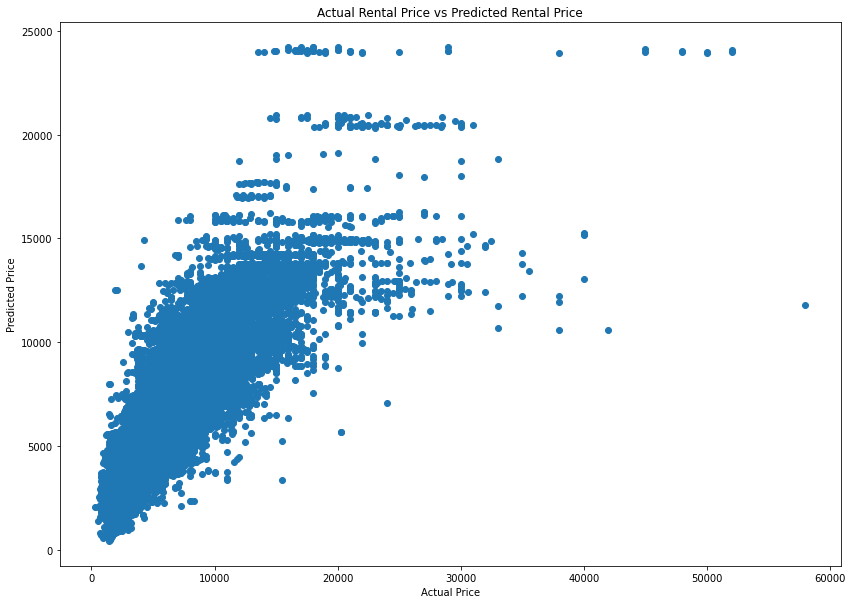

In [34]:
# Visualizing actual prices vs predicted values
pyplot.figure(figsize=[14, 10])
pyplot.scatter(y_train, y_pred_train)
pyplot.xlabel("Actual Price")
pyplot.ylabel("Predicted Price")
pyplot.title("Actual Rental Price vs Predicted Rental Price")
pyplot.show()

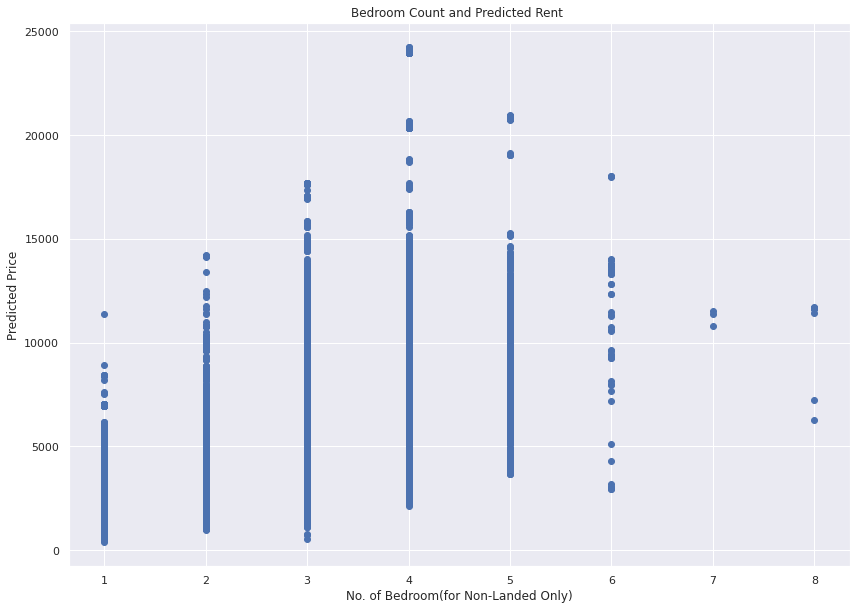

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

In [25]:
pyplot.figure(figsize=[14, 10])
pyplot.scatter(complete_trained_data_copy[col_num_bedroom],complete_trained_data_copy[col_predicted_price])
pyplot.title("Bedroom Count and Predicted Rent ")
pyplot.xlabel(col_num_bedroom)
pyplot.ylabel(col_predicted_price)
pyplot.show()
sns.despine

# complete_trained_data_copy[col_building_name, col_postal_district, col_num_bedroom, col_street_name,
#                             col_floor_area_nosqft, col_actual_price, col_predicted_price]

<Figure size 1008x720 with 0 Axes>

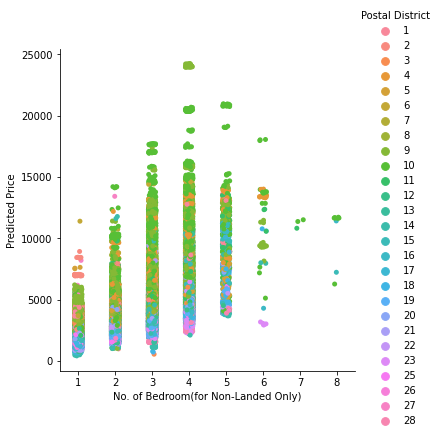

In [9]:
pyplot.figure(figsize=[14, 10])
sns.color_palette("Spectral", as_cmap=True)
plt_room = sns.catplot(data = complete_trained_data_copy, x= col_num_bedroom, y = col_predicted_price, hue = col_postal_district)
# plt_room.title('Room Count vs Predicted Price')
pyplot.show()

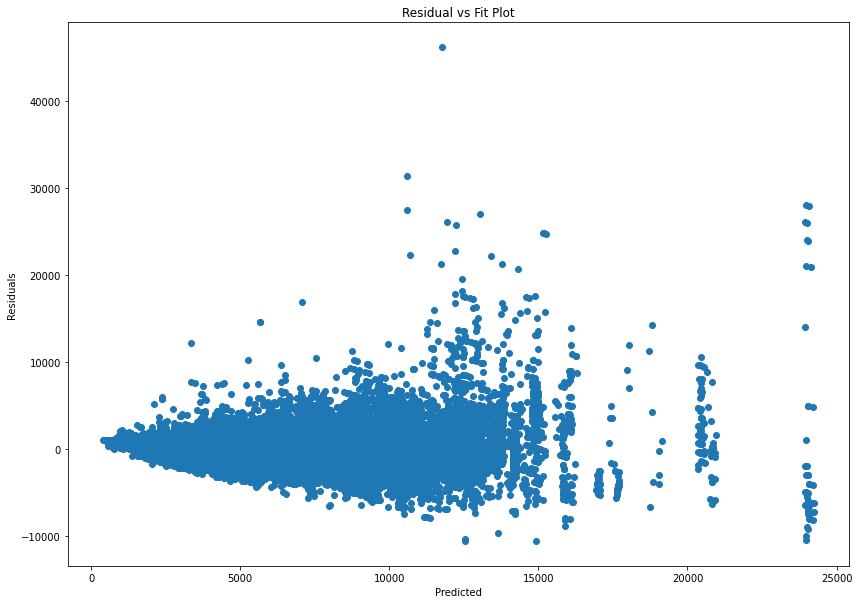

In [35]:
# Equal error variance
# Residual vs fit plot
# Residual plots can be used to analyse whether or not a linear regression model is appropriate for the data.
pyplot.figure(figsize=[14, 10])
pyplot.scatter(y_pred_train, y_train - y_pred_train)
pyplot.title("Residual vs Fit Plot")
pyplot.xlabel("Predicted")
pyplot.ylabel("Residuals")
pyplot.show()

In [22]:
# from pandasgui import show
# show(complete_trained_data_copy[[col_building_name, col_postal_district, col_num_bedroom, col_street_name,
#                             col_floor_area_nosqft, col_actual_price, col_predicted_price]])

In [11]:
# import dtale
# import dtale.app as dtale_app
# dtale.show(complete_trained_data_copy[[col_building_name, col_postal_district, col_num_bedroom, col_street_name,
#                             col_floor_area_nosqft, col_actual_price, col_predicted_price]])

In [1]:
# # Display heatmap
# pyplot.figure(figsize=[10, 6])
# # The correlation matrix can be used to estimate the linear historical relationship between the returns of multiple assets. 
# corrMatrix = X_train.corr()
# sns.heatmap(corrMatrix, annot=True)
# pyplot.show()

In [34]:
# pyplot.figure(figsize=[14, 10])
# # sns.color_palette("Spectral", as_cmap=True)
# plt_build = sns.catplot(data = complete_trained_data_copy, x= col_building_name, y = col_predicted_price, hue = col_floor_area_nosqft)
# # plt_build.title('Building vs Predicted Price')
# pyplot.show()

In [33]:
# pyplot.figure(figsize=[14, 10])
# # pyplot.scatter(complete_trained_data_copy[col_floor_area_nosqft], complete_trained_data_copy[col_predicted_price])
# # pyplot.title("Square Feet vs Predicted Rent")
# # pyplot.xlabel(col_floor_area)
# # pyplot.ylabel(col_monthly_rent)

# sns.catplot(data = complete_trained_data_copy, x= col_floor_area_nosqft, y = col_predicted_price, hue = col_postal_district)


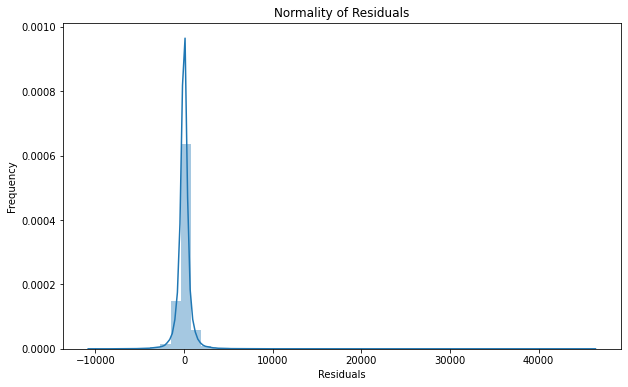

In [36]:
# Normality of residuals - Normal error
#  Since the residuals measure where the points fall in relation to
# the line, a symmetric distribution of the residuals indicates that the same number of points fall
# above and below the line. Since a residual of 0 means a point is right on the line, a mean of 0
# indicates the line is in the middle of the points. Once again, some are above and some are below.
# And the bell shape means that most are close to the line, and there are fewer points farther from
# the line.
pyplot.figure(figsize=[10, 6])
sns.distplot(y_train - y_pred_train)
pyplot.title("Normality of Residuals")
pyplot.xlabel("Residuals")
pyplot.ylabel("Frequency")
pyplot.show()

In [25]:
# numerical_cols = [ col_postal_district, col_num_bedroom]
# X_plot = X.loc[:,numerical_cols]
# fig, axs = pyplot.subplots(ncols=len(numerical_cols), nrows=1, figsize=(12, 4))

# axs = axs.flatten()
# for i, k in enumerate(numerical_cols):
#     sns.regplot(y=y, x=X_plot[k], ax=axs[i], scatter_kws={"color": "teal"}, line_kws={"color": "red"})
# pyplot.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)


In [32]:
# pyplot.figure(figsize=[14, 10])
# pyplot.scatter(complete_trained_data_copy[col_floor_area_nosqft], complete_trained_data_copy[col_predicted_price])
# pyplot.title("Square Feet vs Rent")
# pyplot.xlabel(col_floor_area)
# pyplot.ylabel(col_predicted_price)
# pyplot.show()
# sns.despine

# # complete_trained_data_copy[col_building_name, col_postal_district, col_num_bedroom, col_street_name,
# #                             col_floor_area_nosqft, col_actual_price, col_predicted_price]

In [ ]:
# pyplot.figure(figsize=[14, 10])
# pyplot.scatter(complete_trained_data_copy[col_building_name], complete_trained_data_copy[col_predicted_price])

# pyplot.title("Building vs Rent")
# pyplot.xlabel(col_building_name)
# pyplot.ylabel(col_predicted_price)
# pyplot.xticks(
#     rotation=90, 
#     horizontalalignment='right',
#     fontweight='light',
#     fontsize='x-large'  
# )

In [27]:
# pyplot.figure(figsize=[14, 10])
# sns.color_palette("Spectral", as_cmap=True)
# sns.catplot(data = complete_trained_data_copy, x= col_floor_area_nosqft, y = col_predicted_price, hue = col_postal_district)
# # plt_room.title('Room Count vs Predicted Price')
# # pyplot.show()

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

Text(0, 0.5, 'Monthly Gross Rent($)')

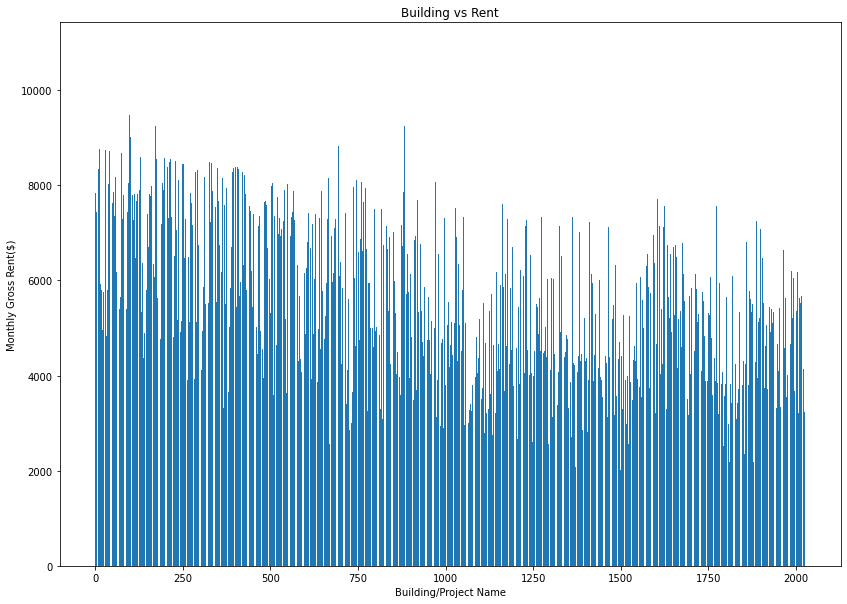

In [20]:
# # pyplot.figure(figsize=[14, 10])
# # pyplot.bar(X_train[col_building], y_pred_train)
# # # This is the location for the annotated text
# # i = 1.0
# # j = 2000

# # # # Annotating the bar plot with the values 
# # # for i in range(len(X_train[col_lease_date])):
# # #     plt.annotate(y_pred_train[i], (-0.1 + i, y_pred_train[i] + j))

# # pyplot.title("Building vs Rent")
# # pyplot.xlabel(col_building)
# # pyplot.ylabel(col_monthly_rent)

In [1]:
# pyplot.figure(figsize=[14, 10])
# pyplot.bar(complete_trained_data_copy[col_building_name], complete_trained_data_copy[col_predicted_price])

# pyplot.title("Building vs Rent")
# pyplot.xlabel(col_building_name)
# pyplot.ylabel(col_predicted_price)
# pyplot.xticks(
#     rotation=90, 
#     horizontalalignment='right',
#     fontweight='light',
#     fontsize='x-large'  
# )

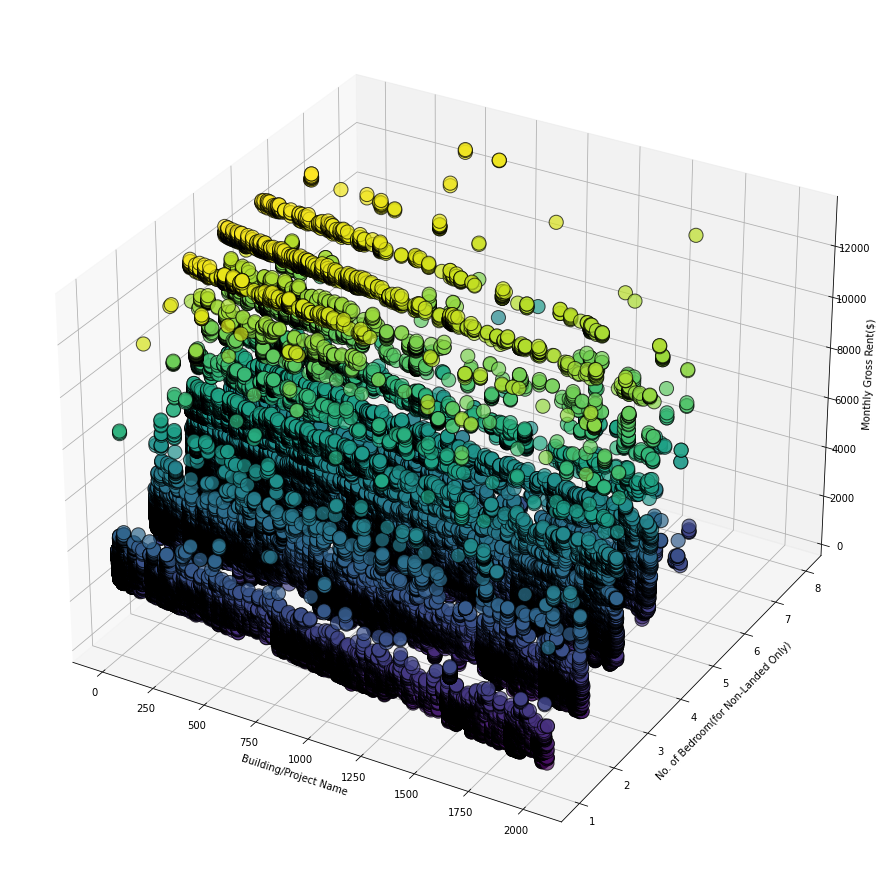

In [34]:
# fig = pyplot.figure(figsize=(16, 16))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_train[col_building], X_train[col_num_bedroom], y_pred_train,
#            linewidths=1, alpha=.7,
#            edgecolor='k',
#            s = 200,
#            c=y_pred_train)
# ax.set_xlabel(col_building)
# ax.set_ylabel(col_num_bedroom)
# ax.set_zlabel(col_monthly_rent)
# pyplot.show()

In [35]:
# X_train[col_num_bedroom].value_counts().plot(kind='bar')
# pyplot.title('number of Bedroom')
# pyplot.xlabel('Bedrooms')
# pyplot.ylabel('Count')
# sns.despine

#### Take away

###### What could have been better?